# CIFAR-10 softmax regression

## Exercise - Load and preprocess data

> **Exercise**: Load the data from the `cifar10-6k.npz` file. Split it into train/validation/test sets with respectively 5,000/500/500 images. Standardize them. Define a `get_batches(X, y, batch_size)` function to generate X/y batches of size `batch_size` using a Python generator.

In [58]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [12]:
# Load data
with np.load('cifar10-6k.npz', allow_pickle=False) as npz_file:
    # Load items into a dictionary
    cifar = dict(npz_file.items())

print(cifar['data'].shape)
print(cifar['labels'].shape)
cifar

(6000, 3072)
(6000,)


{'data': array([[ 59,  62,  63, ..., 123,  92,  72],
        [154, 177, 187, ..., 143, 133, 144],
        [255, 255, 255, ...,  80,  86,  84],
        ...,
        [250, 253, 254, ..., 240, 233, 229],
        [136, 167, 138, ...,  31,  82,  35],
        [170, 182, 189, ...,  92, 109, 118]], dtype=uint8),
 'labels': array([6, 9, 9, ..., 9, 4, 8], dtype=int32),
 'names': array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
        'horse', 'ship', 'truck'], dtype='<U10')}

In [13]:
# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    # Convert uint8 pixel values to float
    cifar['data'].astype(np.float32), # that way we won't get warnings if we need to standardize later
    cifar['labels'],
    test_size=1000, random_state=0
)

# Split again into validation/test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test,
    test_size=500, random_state=0
)

print('Train:', X_train.shape, y_train.shape)
print('Validation:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (5000, 3072) (5000,)
Validation: (500, 3072) (500,)
Test: (500, 3072) (500,)


In [18]:
# Standardize values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [19]:
# Function to get batches of data
def get_batches(X, y, batch_size):
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # "yield" data between index i and i+b (not included)
        yield X[i:i+batch_size], y[i:i+batch_size]

## Exercise - Build and train model

> **Exercise:** Create a softmax regression network for the CIFAR-10 images. Define the graph (placeholders, variables, operations, loss function, optimizer) and train it using your batch generator.

**Hint**: Test different learning rates.

### Define the graph

In [70]:
# Create placeholders
X = tf.placeholder(dtype=tf.float32, shape=[None, 3072]) # None if we don't know the number
y = tf.placeholder(dtype=tf.int32, shape=[None])

# Create variables
W = tf.Variable(initial_value=tf.zeros(shape=[3072, 10]))
b = tf.Variable(initial_value=tf.zeros(shape=[10]))

# Compute logits
logits = tf.matmul(X, W) + b

# Cross-entropy loss function (without one-hot encoding)
ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=y, logits=logits)

# Mean cross-entropy
mean_ce = tf.reduce_mean(ce)

# Gradient descent
lr = tf.placeholder(dtype=tf.float32, shape=[])
gd = tf.train.GradientDescentOptimizer(
    learning_rate=lr)

# Minimize cross-entropy
train_op = gd.minimize(mean_ce)


# Compute predictions
predictions = tf.argmax(
    logits, # shape: (n, 10)
    axis=1, # class with max logit
    output_type=tf.int32 # Same type as labels
)

# Are the predictions correct?
is_correct = tf.equal(y, predictions)

# Accuracy
accuracy = tf.reduce_mean(
    # Convert booleans (false/true) to 0/1 float numbers
    tf.cast(is_correct, dtype=tf.float32)
)

### train using the batch generator

In [94]:
# Accuracy score after each batch of data
acc_values = []
valid_acc_values = []


# Initialization operation
initialization_op = tf.global_variables_initializer()

with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)

    # Get batches of data
    for X_batch, y_batch in get_batches(X_train, y_train, 64):
        # Run training and evaluate accuracy
        _, batch_acc = sess.run([train_op, accuracy], feed_dict={
            X: X_batch,
            y: y_batch,
            lr: 0.0021 # learning rate
        })
        acc_values.append(batch_acc)
        
        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid
        })
        valid_acc_values.append(valid_acc)

    # Get weight matrix and biases
    W_fitted = W.eval()
    b_fitted = b.eval()

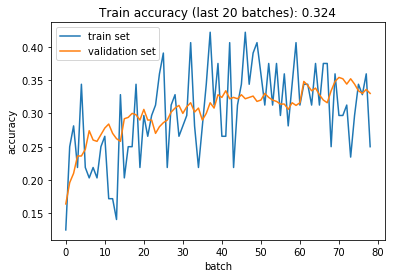

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(acc_values, label= "train set")
plt.plot(valid_acc_values, label="validation set")
plt.title('Train accuracy (last 20 batches): {:.3f}'.format(
    # Average accuracy value
    np.mean(acc_values[-20:])
))
plt.legend()
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.show()

## Exercise - Plot templates

> **Exercise**: Plot the templates of each output neuron. If you use the `imshow(array)` function to plot the array of weights, remember that it expects values between zero and one for 3-dimensional arrays. You can use the `MinMaxScaler` object from Scikit-learn to rescale the weights.

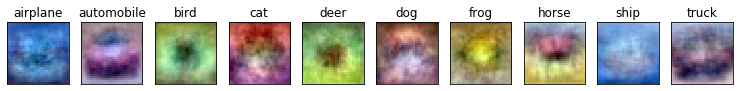

In [96]:
# Rescale each column of the weights matrix between 0 and 1
W_fitted_scaled = MinMaxScaler().fit_transform(W_fitted)

# Create figure with 10 subplots
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(13, 2))

# Plot the weights for each class in a subplot
for i, axis in enumerate(axes):
    # Get weights of the i-th class
    weights = W_fitted_scaled[:, i]

    # Reshape weight values into a 32x32 array
    template = weights.reshape(32, 32,3)

    # Plot array
    axis.set_title(cifar['names'][i])
    axis.imshow(template) # Grayscale (reversed)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis

plt.show()

## Exercise - Evaluate model

> **Exercise**: Evaluate the accuracy of your network on the test set.

In [97]:
with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)
    
    # Compute test accuracy
    acc_val = sess.run(accuracy, feed_dict={
        X: scaler.transform(X_test), # Rescale data
        y: y_test,
        W: W_fitted, # Set weights
        b: b_fitted # Set biases
    })
    print('Test accuracy: {:.3f}'.format(acc_val))

Test accuracy: 0.320


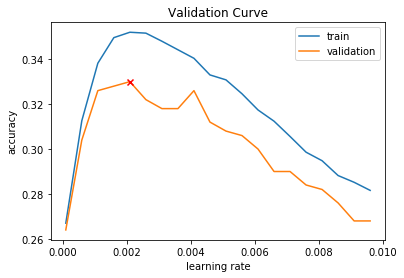

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt

# Accuracy scores for one epoch (over the entire data)
train_acc_epoch = []
valid_acc_epoch = []

# Network Parameters
params_W = []
params_b = []

lr_vals=np.arange(0.0001, 0.01, 0.0005)


for i in np.arange(len(lr_vals)):
    # Initialization operation
    initialization_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        # Initialize the graph
        sess.run(initialization_op)

        # Get batches of data
        for X_batch, y_batch in get_batches(X_train, y_train, 64):
            # Run training and evaluate accuracy
            _ = sess.run([train_op], feed_dict={
            X: X_batch,
            y: y_batch,
            lr: lr_vals[i] # Learning rate
            })

        # Evaluate train accuracy on entire data   ---> note it is outside the loop over batches
        train_acc = sess.run(accuracy, feed_dict={
            X: X_train,
            y: y_train})

        train_acc_epoch.append(train_acc)


        # Evaluate validation accuracy ---> note it is outside the loop over batches
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid})

        valid_acc_epoch.append(valid_acc)

        # Get weight matrix and biases
        params_W.append(W.eval())
        params_b.append(b.eval())

# Plot accuracy values
plt.plot(lr_vals,train_acc_epoch, label='train')
plt.plot(lr_vals,valid_acc_epoch, label='validation')
# Add marker for best score
best_idx = np.argmax(valid_acc_epoch)
plt.scatter(lr_vals[best_idx], max(valid_acc_epoch), marker='x', c='red', zorder=10)
plt.title('Validation Curve')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [93]:
lr_vals[best_idx]

0.0021